In [3]:
from collections import defaultdict
import dotenv
import json
import pandas as pd
import nltk
import numpy as np

# import util
from third_party.nltk_book import chunkers

from src.features import build_features


In [4]:
config = dotenv.dotenv_values(dotenv_path=dotenv.find_dotenv())

In [5]:
# data_config = util.get_data_config()

In [6]:
nltk.download(['punkt', 'averaged_perceptron_tagger'])
# Optional
nltk.download(['brown', 'conll2000',])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

# Load Data

In [7]:
summaries = pd.read_parquet(config['summaries_file_name'])
summaries.shape

(51, 2)

In [8]:
summaries.head()

,nct_id,brief_summary
0,NCT00037648,The purpose of this study is to determine the ...
1,NCT00048542,"This is a multicenter, Phase 3 randomized, pla..."
2,NCT00071487,The purpose of this study is to evaluate the s...
3,NCT00071812,The purpose of this study is to evaluate the s...
4,NCT00072839,The purpose of the study is to determine wheth...


In [9]:
synonyms_df = pd.read_parquet(config['processed_synonyms_file_name'])
synonyms_df.head()

,preferred_name,synonyms
id,,
4.0,levobupivacaine,"[chirocain, levobupivacaine, levobupivacaine H..."
5.0,(S)-nicardipine,"[(-)-Nicardipine, (-)-nicardipine, (S)-nicardi..."
6.0,(S)-nitrendipine,"[(-)-Nitrendipine, (-)-nitrendipine, (S)-nitre..."
13.0,levdobutamine,"[LY206243, levdobutamine, levdobutamine lactob..."
21.0,aminopterin,"[4-aminofolic acid, Aminofolic acid, 4-, amino..."


In [10]:
with open(config['ground_truth_raw_file_name'], 'r') as fin:
    ground_truth = json.loads(fin.read())
    
with open(config['ground_truth_cleaned_file_name'], 'r') as fin:
    ground_truth_cleaned = json.loads(fin.read())

# Process Data

In [11]:
# TODO: check if this introduces a bug.
# synonyms_df['synonyms'] = synonyms_df['synonyms'].map(lambda synonyms: [util.clean_up_synonym_term(synonym) for synonym in synonyms])


synonyms_df['synonyms'] = synonyms_df['synonyms'].map(lambda synonyms: list(set([synonym.lower() for synonym in synonyms])))


In [12]:
synonyms_df.head()

,preferred_name,synonyms
id,,
4.0,levobupivacaine,"[levobupivacaine, levobupivacaine hcl, chiroca..."
5.0,(S)-nicardipine,"[(s)-nicardipine, (-)-nicardipine]"
6.0,(S)-nitrendipine,"[(-)-nitrendipine, (s)-nitrendipine]"
13.0,levdobutamine,"[levdobutamine, levdobutamine lactobionate, ly..."
21.0,aminopterin,"[4-aminofolic acid, aminopterin sodium, aminof..."


In [13]:
word_set = set(
    word
    for synonyms in synonyms_df['synonyms']
    for synonym in synonyms
    for word in synonym.split()
)
print(f'vocabulary size: {len(word_set)}')
characters = set([char for word in word_set for char in word])
extra_characters = [char for char in characters if not char.isalpha()]
print(f'extra characters{sorted(extra_characters)}')

vocabulary size: 19275
extra characters['&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '>', '[', ']', '–']


In [14]:
summaries['brief_summary_raw'] = summaries['brief_summary'].copy()
summaries['brief_summary'] = summaries['brief_summary'].map(build_features.prerpocess_text)

In [15]:
all_tokens = []
all_synonyms = []
dataset_by_ngram = defaultdict(list)
for synonyms in synonyms_df['synonyms']:
    for synonym in synonyms:
        tokens = build_features.prerpocess_text(synonym)
        all_tokens.append(tokens)
        all_synonyms.append(synonym)
        tags = []
        for token in tokens[:-1]:
            # tags.append((token, f'C-{len(tokens)}-S'))
            tags.append((token, f'C{len(tokens)}S'))
            
        for token in tokens[-1:]:
            # tags.append((token, f'C-{len(tokens)}-E'))
            tags.append((token, f'C{len(tokens)}E'))
        
        assert len(tags) == len(tokens)
        dataset_by_ngram[len(tags)].append(tags)

syn_counts_df = pd.DataFrame({
    'synonym': all_synonyms,
    'tokens': all_tokens,
})
syn_counts_df['token_count'] = syn_counts_df['tokens'].map(len)
syn_counts_df.head(10)

,synonym,tokens,token_count
0,levobupivacaine,[levobupivacaine],1
1,levobupivacaine hcl,"[levobupivacaine, hcl]",2
2,chirocain,[chirocain],1
3,levobupivacaine hydrochloride,"[levobupivacaine, hydrochloride]",2
4,(s)-nicardipine,"[(, s, ), -nicardipine]",4
5,(-)-nicardipine,"[(, -, ), -nicardipine]",4
6,(-)-nitrendipine,"[(, -, ), -nitrendipine]",4
7,(s)-nitrendipine,"[(, s, ), -nitrendipine]",4
8,levdobutamine,[levdobutamine],1
9,levdobutamine lactobionate,"[levdobutamine, lactobionate]",2


In [16]:
syn_counts_df['token_count'].value_counts()

token_count
1     15647
2      6049
3       816
4       460
5       166
6        64
7        10
8         9
9         4
14        1
19        1
Name: count, dtype: int64

# NgramTagger that uses N-1 tokens (instead of N-1 tags). 

We train a series of `NgramTagger`s, one for each ngram size in the ground truth, The tagger with the highest `N` is applied first and if it cannot tag a temrm it uses the tager with the next lowest `N`. 

In [17]:
def parse(text, parser, tagger):
    tagged = tagger.tag(build_features.prerpocess_text(text))
    tree = parser.parse(tagged)
    return tree

def extract_chunked_terms(tree: nltk.Tree, chunk_tag: str = 'NP') -> list[str]:
    terms = []
    for subtree in tree:
        if type(subtree) != nltk.Tree:
            continue
        if subtree.label() != chunk_tag:
            continue
        term = ''.join([leaf[0] for leaf in subtree.leaves()])
        terms.append(term)
    return terms

class WordNgramTagger(nltk.NgramTagger):
    """
    My override of the NLTK NgramTagger class that considers previous
    tokens rather than previous tags for context.
    """
    def __init__(self, n, train=None, model=None,
                 backoff=None, cutoff=0, verbose=False):
        nltk.NgramTagger.__init__(self, n, train, model, backoff, cutoff, verbose)

    def context(self, tokens, index, history):
        tag_context = tuple(tokens[max(0,index-self._n+1):index])
        return tag_context, tokens[index]
    

In [18]:
taggers = [nltk.DefaultTagger('O')]
for n in sorted(dataset_by_ngram.keys()):
    print(n)
    train = dataset_by_ngram[n]
    ngram_tagger = WordNgramTagger(n=n, train=train, backoff=taggers[-1])
    taggers.append(ngram_tagger)

tagger = taggers[-1]

1
2
3
4
5
6
7
8
9
14
19


## Try a RegexpParser as a Chunker.

In [20]:
grammar = '''NP: {<C1E>}'''
for num_tokens in dataset_by_ngram.keys():
    if num_tokens == 1:
        continue
    grammar += '\n{<C\dS>{' + str(num_tokens-1) + '}<C' + str(num_tokens) + 'E>}'
print(grammar)
regexp_parser = nltk.RegexpParser(grammar)

NP: {<C1E>}
{<C\dS>{1}<C2E>}
{<C\dS>{3}<C4E>}
{<C\dS>{2}<C3E>}
{<C\dS>{4}<C5E>}
{<C\dS>{13}<C14E>}
{<C\dS>{5}<C6E>}
{<C\dS>{7}<C8E>}
{<C\dS>{6}<C7E>}
{<C\dS>{8}<C9E>}
{<C\dS>{18}<C19E>}


In [21]:
all_terms = [
    synonym
    for synonyms in synonyms_df['synonyms']
    for synonym in synonyms
]
all_trees = [
    parse(term, parser=regexp_parser, tagger=tagger)
    for term in all_terms
]
extracted = [
    extract_chunked_terms(tree) for tree in all_trees
]

df = pd.DataFrame({
    'term': all_terms,
    'tree': all_trees,
    'extracted': extracted
})

In [22]:
df['extracted_count'] = df['extracted'].map(len)
df['extracted_count'].value_counts()

extracted_count
1    20634
0     2593
Name: count, dtype: int64

In [23]:
df.head(10)

,term,tree,extracted,extracted_count
0,levobupivacaine,"[(levobupivacaine, C2S)]",[],0
1,levobupivacaine hcl,"[[(levobupivacaine, C2S), (hcl, C2E)]]",[levobupivacainehcl],1
2,chirocain,"[[(chirocain, C1E)]]",[chirocain],1
3,levobupivacaine hydrochloride,"[[(levobupivacaine, C2S), (hydrochloride, C2E)]]",[levobupivacainehydrochloride],1
4,(s)-nicardipine,"[[((, C9S), (s, C8S), (), C8S), (-nicardipine,...",[(s)-nicardipine],1
5,(-)-nicardipine,"[[((, C9S), (-, C9S), (), C9S), (-nicardipine,...",[(-)-nicardipine],1
6,(-)-nitrendipine,"[[((, C9S), (-, C9S), (), C9S), (-nitrendipine...",[(-)-nitrendipine],1
7,(s)-nitrendipine,"[[((, C9S), (s, C8S), (), C8S), (-nitrendipine...",[(s)-nitrendipine],1
8,levdobutamine,"[(levdobutamine, C2S)]",[],0
9,levdobutamine lactobionate,"[[(levdobutamine, C2S), (lactobionate, C2E)]]",[levdobutaminelactobionate],1


In [24]:
def is_correct(term: str, extracted: list[str]) -> bool:
    if not extracted:
        return False
    return term.replace(' ', '') == extracted[0]
df['correct'] = df.apply(lambda row: is_correct(row['term'], row['extracted']), axis=1)
print(f'Accuracy: {df.correct.mean():.2%}')

Accuracy: 88.84%


In [25]:
df['term_token_count'] = df['term'].map(lambda term: len(nltk.word_tokenize(term)))

In [26]:
df[df['extracted_count']==0].term_token_count.value_counts()

term_token_count
1     2202
2      362
3       23
4        4
14       1
19       1
Name: count, dtype: int64

In [27]:
_df = df[df['extracted_count']==0].copy()
_df

,term,tree,extracted,extracted_count,correct,term_token_count
0,levobupivacaine,"[(levobupivacaine, C2S)]",[],0,False,1
8,levdobutamine,"[(levdobutamine, C2S)]",[],0,False,1
14,aminopterin,"[(aminopterin, C2S)]",[],0,False,1
45,5-fluorouracil,"[(5-fluorouracil, C2S)]",[],0,False,1
76,abacavir,"[(abacavir, C2S)]",[],0,False,1
...,...,...,...,...,...,...
23155,ensitrelvir,"[(ensitrelvir, C3S)]",[],0,False,1
23162,ritlecitinib,"[(ritlecitinib, C2S)]",[],0,False,1
23178,durlobactam,"[(durlobactam, C2S)]",[],0,False,1
23183,tofersen,"[(tofersen, C2S)]",[],0,False,1


In [28]:
_df[_df['term_token_count']==2]

,term,tree,extracted,extracted_count,correct,term_token_count
136,acefylline piperazine,"[(acefylline, C3S), (piperazine, C3S)]",[],0,False,2
246,acetopromazine maleate,"[(acetopromazine, C3S), (maleate, C3S)]",[],0,False,2
322,adenosine triphosphate,"[(adenosine, C4S), (triphosphate, C4S)]",[],0,False,2
421,alendronate sodium,"[(alendronate, C4S), (sodium, C3S)]",[],0,False,2
552,alverine citrate,"[(alverine, C3S), (citrate, C3S)]",[],0,False,2
...,...,...,...,...,...,...
22429,efgartigimod alfa,"[(efgartigimod, C6S), (alfa, C6S)]",[],0,False,2
22653,iron dextran,"[(iron, C4S), (dextran, C3S)]",[],0,False,2
22661,laidlomycin propionate,"[(laidlomycin, C3S), (propionate, C3S)]",[],0,False,2
22798,sodium sulfachloropyrazine,"[(sodium, C8S), (sulfachloropyrazine, C3S)]",[],0,False,2


# Create Chunker training data and ground truth

In [29]:
def create_chunk_tree(nodes: list[tuple[str, str]], chunk_tag: str = 'NP') ->nltk.Tree:
    return nltk.Tree(chunk_tag, nodes)


def get_random_filler_trees(words: list[str], size=3, tag='O') -> list[nltk.Tree]:
    trees = []
    selection = np.random.choice(words, size).tolist()
    for word in selection:
        # trees.append(nltk.Tree(word, [tag]))
        trees.append((word, tag))
    return trees


def get_synonym_tags(tokens: list[str]) -> list[tuple[str, str]]:
    """Creates tags for a single synonym word, the word must be tokenized already."""
    synonym_tags = []
    for token in tokens[:-1]:
        synonym_tags.append((token, f'C{len(tokens)}S'))
        
    for token in tokens[-1:]:
        synonym_tags.append((token, f'C{len(tokens)}E'))
    return synonym_tags


def split_summary_by_keywords(brief_summary: str, keywords: list[str]) -> str:
    tokens = [brief_summary]
    for keyword in keywords:
        new_tokens = []
        for token in tokens:
            split_tokens = token.split(keyword)
            for index, split_token in enumerate(split_tokens):
                new_tokens.append(split_token)
                if index < len(split_tokens) - 1:
                    new_tokens.append(keyword)
        tokens = new_tokens
    return tokens


def get_synonym_subtree(synonym):
    tokens = nltk.word_tokenize(synonym)    
    synonym_tags = get_synonym_tags(tokens)
        
    tree = create_chunk_tree(synonym_tags)
    return tree


def get_gt_tree(brief_summary: str, keywords: list[str]) -> nltk.Tree:
    tokens = split_summary_by_keywords(brief_summary, keywords)
    tree = []
    for part in tokens:
        if part in keywords:
            tree.append(get_synonym_subtree(part))
        else:
            tree.extend([(t, 'O') for t in nltk.word_tokenize(part)])
    return nltk.Tree('S', tree)


## Chunker training data

Chunker training data is created by using the synonym lists to create tagged trees and interjecting random words which are labeled 'O'.


In [30]:
filler_words = build_features.prerpocess_text(
    'The purpose of this study is to evaluate the safety and efficacy of 3 different doses of '
    'administered in addition to standard therapy, in patients with active SLE disease.'
# ).lower().split()
)

train_tree_synonyms = []
for synonyms in synonyms_df['synonyms']:
    trees = []
    for synonym in synonyms:
        tokens = nltk.word_tokenize(synonym)
        synonym_tags = get_synonym_tags(tokens)
            
        tree = create_chunk_tree(synonym_tags)
        trees.append(tree)
        
        trees.extend(get_random_filler_trees(filler_words))
    
    
    train_tree_synonyms.append(nltk.Tree('S', trees))
        

In [31]:
assert max([t.height() for t in train_tree_synonyms]) == 3

In [32]:
# Check that tree height is at most 3.
# for index, tree in enumerate(train_tree_synonyms):
#     if tree.height()>3:
#         print('found')
#         break

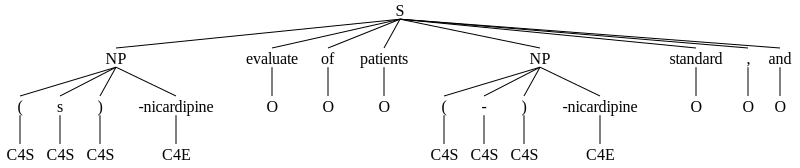

In [33]:
train_tree_synonyms[1]

## Chunker ground truth data

In [34]:
tagger = taggers[-1]
test_trees_gt = []
for _, row in summaries.iterrows():
    nct_id = row['nct_id']
    keywords = [kw.lower() for kw in ground_truth[nct_id]]
    brief_summary_raw = row['brief_summary_raw'].lower()
    
    tree = get_gt_tree(brief_summary_raw, keywords)
    assert ''.join(split_summary_by_keywords(brief_summary_raw, keywords)) == brief_summary_raw
    test_trees_gt.append(tree)

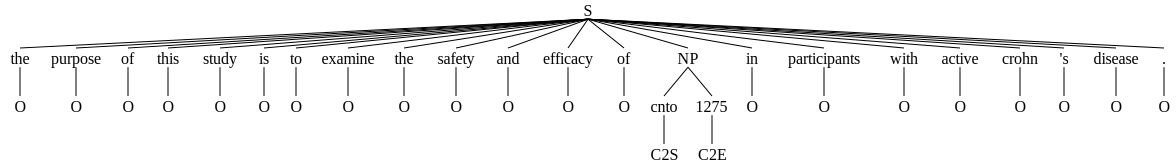

In [35]:
test_trees_gt[45]

# Classifier based chunker

In [36]:
chunker = chunkers.ConsecutiveNPChunker(
    train_sents=train_tree_synonyms,
    feature_generator_fn=build_features.get_feature_generator('npchunk_features_bigram_pos')
)

In [37]:
# Training set evaluation metric for the Chunker.
print(chunker.accuracy(train_tree_synonyms))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


In [38]:
print(chunker.accuracy(test_trees_gt))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


## Test set evaluation metric for the Chunker.

In [39]:
tagger = taggers[-1]
# test_trees = summaries['brief_summary'].map(lambda text: chunker.parse(tagger.tag(text)))
test_trees = summaries['brief_summary_raw'].map(lambda text: parse(text, parser=chunker, tagger=tagger))

In [40]:
max([t.height() for t in train_tree_synonyms])

3

In [41]:
# Note: 100% is too good, the dataset is rather small.
print(chunker.accuracy(test_trees))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


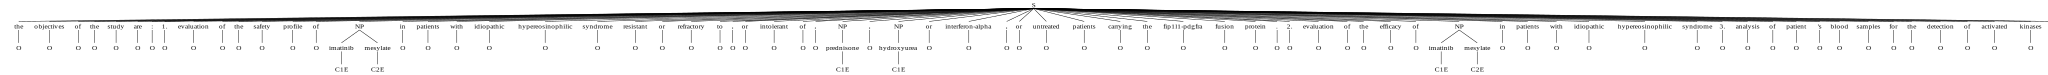

In [42]:
test_trees[26]

## Extract terms and map to preferred names

In [43]:
synonym_maps = build_features.get_synonym_maps(synonyms_df)
preferred_name_by_term = synonym_maps['preferred_name_by_term']

In [44]:
def extract_preferred_names_from_tree(tree, chunk_tag: str = 'NP') -> list[str]:
    terms = extract_chunked_terms(tree=tree, chunk_tag=chunk_tag)
    term_prefered_names = []
    for term_raw in terms:
        term = term_raw.lower()
        # print(term, term_raw)
        if term not in preferred_name_by_term:
            continue
        term_prefered_names.append(preferred_name_by_term[term])
    return list(set(term_prefered_names))    
    

In [45]:
extracted_terms = []
for tree in test_trees:
    extracted_terms.append(extract_preferred_names_from_tree(tree))
test_df = pd.DataFrame({
    'nct_id': summaries['nct_id'],
    'extracted_terms': extracted_terms
})

## Evaluate

In [46]:
test_df['gt_cleaned'] = test_df.nct_id.map(lambda x: ground_truth_cleaned[x])

In [47]:
test_df['match_count'] = test_df.apply(lambda row: len(set(row['extracted_terms']).intersection(set(row['gt_cleaned']))), axis=1)

In [48]:
test_df.head()

,nct_id,extracted_terms,gt_cleaned,match_count
0,NCT00037648,[anakinra],[anakinra],1
1,NCT00048542,"[methotrexate, adalimumab]","[methotrexate, adalimumab]",2
2,NCT00071487,[belimumab],[belimumab],1
3,NCT00071812,[belimumab],[belimumab],1
4,NCT00072839,[teduglutide],[teduglutide],1


In [49]:
test_df['extracted_terms_count'] = test_df['extracted_terms'].map(len)
test_df['gt_cleaned_count'] = test_df['gt_cleaned'].map(len)

In [50]:
true_positive_count = test_df['match_count'].sum()
precision = true_positive_count / test_df['extracted_terms_count'].sum()
recall = true_positive_count / test_df['gt_cleaned_count'].sum()
print(f'Precision: {precision: .2%}')
print(f'Recall: {recall: .2%}')


Precision:  100.00%
Recall:  98.25%


In [51]:
misses_df = test_df[(test_df['match_count'] != test_df['extracted_terms_count']) | (test_df['match_count'] != test_df['gt_cleaned_count'])]
misses_df

,nct_id,extracted_terms,gt_cleaned,match_count,extracted_terms_count,gt_cleaned_count
45,NCT00265122,[],[ustekinumab],0,0,1


### Check specific case(s)

In [52]:
nct_id = 'NCT00265122'

In [53]:
_sum = summaries[summaries['nct_id']==nct_id].brief_summary.iloc[0]
print(_sum)

['the', 'purpose', 'of', 'this', 'study', 'is', 'to', 'examine', 'the', 'safety', 'and', 'efficacy', 'of', 'cnto', '1275', 'in', 'participants', 'with', 'active', 'crohn', "'s", 'disease', '.']


In [54]:
_sum_raw = summaries[summaries['nct_id']==nct_id].brief_summary_raw.iloc[0]
print(_sum_raw)

The purpose of this study is to examine the safety and efficacy of CNTO 1275 in participants with active Crohn's Disease.


In [55]:
index = summaries[summaries['nct_id']=='NCT00265122'].index[0]
index

45

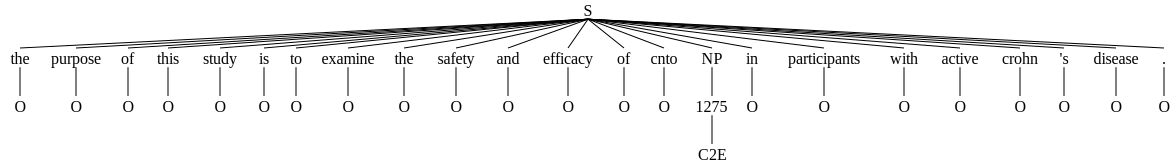

In [56]:
# This is a tagger issue, 'cnto' is tagged as other, it should have been tagged as 'C2E'
test_trees[index]

In [57]:
raw_synonym_maps = build_features.get_synonym_maps(synonyms_df, clean_up_terms=False)
raw_terms_by_preferred_name = raw_synonym_maps['terms_by_preferred_name']

In [58]:
_pref_name = 'ustekinumab'
for term in raw_terms_by_preferred_name[_pref_name]:
    if term in _sum_raw:
        print(term)
raw_terms_by_preferred_name[_pref_name]

['cnto 1275', 'ustekinumab', 'cnto-1275', 'stelara']

# Save

In [55]:
test_df.to_parquet(config['extraction_nltk_file_name'], index=False) 